## 6章: 化合物の類似性を評価してみる
ECFPの図的説明が必要、バーチャルスクリーニングの日本語、MACCS けｙ最高でも 23% の類似度、pymol

### 化合物が似ているとはどういうことか？
２つの化合物が似ているとはどういうことでしょうか？なんとなく形が似ている？という表現は科学的ではありません。ケモインフォマティクスでは類似度(一般的に0-100%値を取ります)や非類似度(距離)といった定量的な尺度により似ているかどうかを評価します。

２つの代表的な評価尺度（分子の全体的な特徴を数値で表現する**記述子**と、部分構造の集合を表現することで分子の特徴を表現する**フィンガープリント**）を紹介します。

### 記述子
分子の全体的な特徴を数値で表現するものを記述子と呼びます。分子量や極性表面性 (PSA)、分配係数 (logP) などがあり、現在までに多くの記述子が提案されています。これらの記述子の類似性を評価することで２つの分子がどのくらい似ているかを表現することが可能です。また分子全体の特徴を 1 つの数字で表現しており局所的な特徴ではないということに注意してください。
#### Note
いくつかの記述子に関しては市販ソフトでないと計算できない場合があります。

### フィンガープリント
フィンガープリントとは分子の部分構造を 0, 1 のバイナリーで表現したもので部分構造の有無とビットの on (1), off (0) を対応させ、部分構造の集合を表現することで分子の特徴を表現しています。フィンガープリント (FP) には固定長 FP と可変長 FP の二種類が存在し、古くは MACCS key という固定長 FP (予め部分構造とインデックスが決められている FP) が使われていましたが、現在では ECFP4 (Morgan2) という可変長 FP が利用されることが多く見られます。

RDKit のフィンガープリントに関しては開発者の Greg さんのスライドが詳しいので熟読してください。

今回はこの ECFP4 (Morgan2) を利用した類似性評価をしてみましょう。

### SMILES とフィンガープリントの違い
SMILES は構造を ASCII 文字列で表現したもの、フィンガープリントは部分構造の有無をバイナリで表現したものです。違いは前者は構造表現の 1 つであるのに対し、後者は特徴表現の一つだということです。 部分構造の有無だけしか表現していないため、部分構造間の関係性（どう位置関係でつながっているのか）といった情報が失われ、もとの構造に戻ることはありません。

テキストマイニングでよく用いられる Bag-of-Words に対応するので Bag-of-Fragments と呼ぶ人もいます。

### 類似度を計算する
簡単な分子例としてトルエンとクロロベンゼンの類似性を評価してみましょう。

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
# from rdkit.Chem.Draw import IPythonConsole

SMILES で分子を読み込みます。

In [2]:
mol1 = Chem.MolFromSmiles("Cc1ccccc1")
mol2 = Chem.MolFromSmiles("Clc1ccccc1")

目視で確認しましょう。

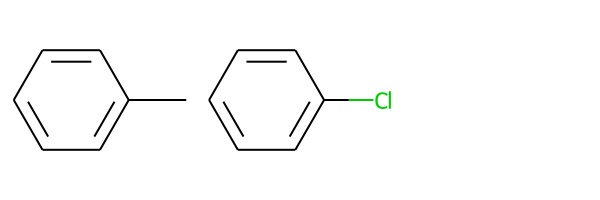

In [3]:
Draw.MolsToGridImage([mol1, mol2])

ECFP4 に相当する半径 2 のモルガンフィンガープリントを生成します。

In [4]:
fp1 = AllChem.GetMorganFingerprint(mol1, 2)
fp2 = AllChem.GetMorganFingerprint(mol2, 2)

類似度の評価にはタニモト係数を使います。

In [5]:
DataStructs.TanimotoSimilarity(fp1, fp2)

0.5384615384615384

類似度の補数（すなわち 1 - 類似度）は、どれくらい離れているかを示す距離となります。距離を求める場合は returnDistance = True とします。 後述のクラスタリングなどでは類似度よりも距離を用いることの方が多いです。

In [6]:
DataStructs.TanimotoSimilarity(fp1, fp2, returnDistance = True)

0.46153846153846156

### バーチャルスクリーニング
化合物の類似性の評価指標を用い多くの化合物の中から特定の化合物群を計算から選び出すことを Ligand-based バーチャルスクリーニングと呼びます。

薬になりそうな化合物が特許や論文で発表されたり、自社のアッセイ系で有望そうな化合物が見つかった場合、自社の化合物ライブラリデータベースや市販化合物のデータベースの中に類似の化合物で、より有望そうなものがあるかどうかを探したいことがあります。

ここでは、ノイラミニダーゼ阻害薬として知られるインフルエンザ治療薬であるイナビルの類似体が購入可能であるかを ZINC を利用して調べます。

イナビルの分子量が約 350, ALogP が -2.92 だったので、ZINC の分子量 350-375, LogP が -1 未満の 340 万化合物の区画を選択しました。この区画は 16 のファイルに分かれていますが、最初の 1 セットだけダウンロードして使ってみます。

#### Note
データのダウンロード方法は 4 章で説明しています。
jupyter notebook では ! で始めると Shell コマンドを実行できます。
jupyter notebook 上で wget コマンドで ZINC のデータセットをダウンロードします。

In [16]:
!bitsadmin.exe /TRANSFER htmldl http://files.docking.org/2D/EA/EAED.smi C:\\Users\ｘｘｘ\Documents\EAED.smi
#need full path


BITSADMIN version 3.0
BITS administration utility.
(C) Copyright Microsoft Corp.

Transfer complete.


!wget http://files.docking.org/2D/EA/EAED.smi
#### NOTE
Windows などで wget コマンドがない場合はブラウザにURLを直接入力するとファイルのダウンロードができるので、ダウンロードしたファイルを Jupyter を起動しているディレクトリに移動してください。

SmilesMolSupplier 関数を使い、ファイルからまとめて SMILES を読み込み mol オブジェクトにします。5 章で紹介した SDMolSupplier の SMILES バージョンと考えてください。

In [17]:
spl = Chem.rdmolfiles.SmilesMolSupplier("EAED.smi")
len(spl)

114943

イナビル (Laninamivir) との類似度を調べるための関数を用意します。

In [18]:
laninamivir = Chem.MolFromSmiles("CO[C@H]([C@H](O)CO)[C@@H]1OC(=C[C@H](NC(=N)N)[C@H]1NC(=O)C)C(=O)O")
laninamivir_fp = AllChem.GetMorganFingerprint(laninamivir, 2)

def calc_laninamivir_similarity(mol):
    fp = AllChem.GetMorganFingerprint(mol, 2)
    sim = DataStructs.TanimotoSimilarity(laninamivir_fp, fp)
    return sim

関数を用いて、類似度を計算してみましょう。

In [19]:
similar_mols = []
for mol in spl:
    sim = calc_laninamivir_similarity(mol)
    if sim > 0.2:
        similar_mols.append((mol, sim))

結果を類似度の高い順に並べ替えて最初の10件だけ取り出します。

In [20]:
similar_mols.sort(key=lambda x: x[1], reverse=True)
mols = [l[0] for l in similar_mols[:10]]

描画してみましょう。

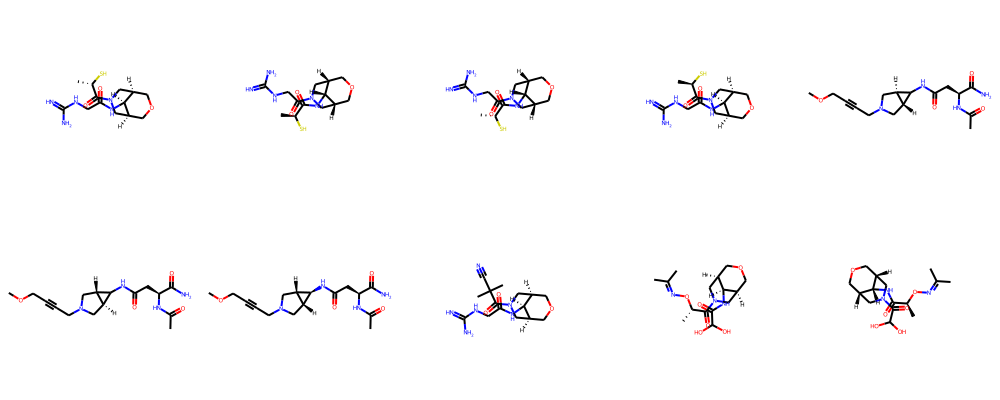

In [21]:
Draw.MolsToGridImage(mols, molsPerRow=5)

類似度を確認すればわかりますが、今回調べた約 11 万件の化合物は最高でも 23% の類似度の化合物しか見いだせませんでした。ZINC は 7 億 5000 万件のデータを収録してあるのでその中にはもっと似ている化合物はたくさんあるはずです。

### クラスタリング
市販化合物を購入してライブラリを作る場合に、できるだけ多様性を持たせる目的で、似ている化合物ばかりが偏らないように類似化合物同士をまとめ、その中の代表を選ぶことがあります。化合物を構造の類似性でまとめたい場合、クラスタリングという手法を使います。

Novartis の抗マラリアアッセイの 5614 件のヒット化合物を例にクラスタリングを実施してみましょう。

クラスタリング用のライブラリをインポートし、データを読み込みます。

In [ ]:
from rdkit.ML.Cluster import Butina
mols = Chem.SDMolSupplier("ch06_nov_hts.sdf")

何らかの理由で RDKit で分子の読み込みができない場合、mol オブジェクトではなく None が生成されます。

None を GetMorganFingerprintAsBitVect 関数にわたすとエラーになるので、None を除きながらフィンガープリントを生成します。

In [ ]:
fps = []
valid_mols = []

for mol in mols:
    if mol is not None:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
        fps.append(fp)
        valid_mols.append(mol)

フィンガープリントから距離行列（下三角の距離行列）を生成します。ある化合物を参照化合物とし、複数の化合物の間の類似度や距離を計算する時は DataStructs.BulkTanimotoSimilarity を用いるとまとめて計算ができます。

In [ ]:
distance_matrix = []
for i, fp in enumerate(fps):
    distance = DataStructs.BulkTanimotoSimilarity(fps[i], fps[:i+1], returnDistance = True)
    distance_matrix.extend(distance)

距離行列を用いて化合物をクラスタリングします。3 番目の引数は距離の閾値です。この例では距離 0.2 つまり 80% 以上の類似度の化合物でクラスタリングしています。

In [ ]:
clusters = Butina.ClusterData(distance_matrix, len(fps), 0.2, isDistData = True)

クラスタ数を確認しましょう。

In [ ]:
len(clusters)

In [ ]:
最初のクラスタの構造を表示してみましょう。

In [ ]:
mols_ = [valid_mols[i] for i in clusters[0]]
Draw.MolsToGridImage(mols_, molsPerRow = 5)

今回は　RDKit　に用意されているライブラリでクラスタリングを行いましたが、Scikit-learn　でも幾つかの手法が利用できますし、実際にはこちらの方を使うことが多いです。

### Structure Based Drug Design (SBDD)
抗凝固薬として上市されている apixaban, rivaroxaban の類似性を評価してみましょう。

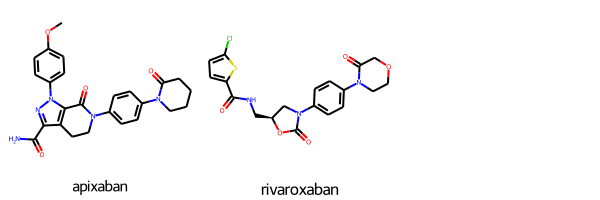

In [22]:
apx = Chem.MolFromSmiles("COc1ccc(cc1)n2nc(C(=O)N)c3CCN(C(=O)c23)c4ccc(cc4)N5CCCCC5=O")
rvx = Chem.MolFromSmiles("Clc1ccc(s1)C(=O)NC[C@H]2CN(C(=O)O2)c3ccc(cc3)N4CCOCC4=O")
Draw.MolsToGridImage([apx, rvx], legends=["apixaban", "rivaroxaban"])

構造を見るとなんとなく似ています。2 つの化合物は両方共 FXa というセリンプロテアーゼの同じポケットに同じように結合し、蛋白質の働きを阻害することが知られています。

In [23]:
apx_fp = AllChem.GetMorganFingerprint(apx, 2, useFeatures = True)
rvx_fp = AllChem.GetMorganFingerprint(rvx, 2, useFeatures = True)

In [24]:
DataStructs.TanimotoSimilarity(apx_fp, rvx_fp)

0.40625

40% くらいの類似度ということになりました。実は apixaban も rivaroxaban も複合体結晶構造が解かれており、PyMOL を利用して重ねて描画します。

#### NOTE
本書の内容を超えるので、PyMOLの使い方などについては説明しません。興味があればこの辺りを参考にしてください。


図から、apixaban,　rivaroxaban　は立体的に綺麗に重なっていることが見てとれます。特に、メトキシフェニルとクロロチオールは S1 ポケットと呼ばれる部位に位置しており何らかの強い相互作用をしていると言われています。蛋白質のリガンド結合部位（ポケット）が明確になれば、メディシナルケミストが次にどの辺りを修飾するかの戦略が立てやすくなり、プロジェクトの成功確率や進捗速度も上がります。

X 線やクライオ電験などにより決められた蛋白質の形状に基づいて構造最適化を行うアプローチを Structure Based Drug Design (SBDD) と呼びます。また、ポケットがわかれば、物理的にポケットに結合するような化合物をスクリーニングすることができます。化合物の類似性に基づくリガンドベースのバーチャルスクリーニング (LBVS) に対して、構造ベースのバーチャルスクリーニング (SBVS) と呼びます。

#### FXa 阻害剤の歴史と量子化学計算の重要性
本書のケモインフォマティクスの内容とは大きくかけ離れるのですが、FXa 阻害剤の歴史を辿り、世代を経てどのような改良がなされていったのかを理解するのは分子設計をする上でかなり役に立ちます。S1 ポケットの相互作用の解釈は目視や古典力学では非常に難しく、Fragment Molecular Orbital Method のような量子化学計算によってのみ解釈できるため、今後の分子設計において量子化学計算は必須になることは間違いありません。